In [51]:
import sys
sys.path.append('../')

import tquant as tq
import tensorflow as tf

# from datetime import date, timedelta
# import tensorflow as tf
# import pandas as pd
from datastore import *

tq.Settings.evaluation_date = date(2024, 4, 30)

In [52]:
# rc0 = tq.RateCurve(ir_eur_curve_estr['daycount'].values/365, ir_eur_curve_estr['quote'].values)
rc = tq.RateCurve(ir_eur_curve_estr['daycount'].values/365, ir_eur_curve_estr['quote'].values, 'LINEAR')

In [53]:
def modifica_stringhe(lista_stringhe):
    # Lista per memorizzare le stringhe modificate
    stringhe_modificate = []
    
    # Rimozione del prefisso FRA
    prefisso = "FRA-"
    for stringa in lista_stringhe:
        if stringa.startswith(prefisso):
            stringa = stringa[len(prefisso):]
        stringhe_modificate.append(stringa)

    # Dizionario delle sostituzioni
    sostituzioni = {
        "1BD": "O/N",
        "2BD": "T/N",
        "3BD": "S/N",
        "CASH": "depo",
        "SWAP": "ois",
        "FRA": "fra",
    }

    # Lista temporanea per memorizzare le stringhe modificate ulteriormente
    stringhe_modificate_finali = []

    # Iterare su ciascuna stringa nella lista delle stringhe modificate
    for stringa in stringhe_modificate:
        for chiave, valore in sostituzioni.items():
            stringa = stringa.replace(chiave, valore)
        stringhe_modificate_finali.append(stringa)
    
    return stringhe_modificate_finali

# Helpers and Generators

In [54]:
#bootstrap della estr
generators = modifica_stringhe(ir_eur_curve_estr['type'])
maturities = list(modifica_stringhe(ir_eur_curve_estr['tenor']))
data = [["EUR", "DISCOUNT", "", "EUR:ESTR"]]
attributes = ["CCY", "USAGE"]
curve_assignment = tq.CurveAssignment(data, attributes)

deposit_builder = tq.DepositHelper(tq.Currency.EUR,
                    2,
                    tq.BusinessDayConvention.ModifiedFollowing,
                    tq.DayCounterConvention.Actual360,
                    1.0)


ois_builder = tq.OisHelper(tq.Currency.EUR,
                        2,
                        2,
                        "1Y",
                        tq.BusinessDayConvention.ModifiedFollowing,
                        1.0,
                        tq.DayCounterConvention.Actual360)

generator_map = {"depo": deposit_builder,
                 "ois": ois_builder}

# ZeroCurveStripper

In [5]:
bootstrapping_curve_name = "EUR:ESTR"
trade_date = tq.Settings.evaluation_date
# generators 
# maturities
quotes = ir_eur_curve_estr['quote'].values
# curve_assignment
# generator_map
market_data = {}
solver_type = "GLOBAL"
is_spread_curve = False

In [6]:
print(bootstrapping_curve_name)
products = []
pricers = []

# crea un pricer per ogni generatore della curva 
for i, generator in enumerate(generators):
    builder = generator_map[generator]
    product = builder.build(trade_date, quotes[i], maturities[i])
    products.append(product)
    # print(maturities[i])
    # print(product)
    pricer = tq.PricerAssignment.create(product)
    pricers.append(pricer)

# crea una curva di initial guess con i pillar dei generatori e zero rates flat a 1%
pillars = []
zero_rates = []
act365 = tq.DayCounterConvention.Actual365
day_counter = tq.DayCounter(act365)
for i in range(len(maturities)):
    # lista con le maturity dei generators
    pillars.append(day_counter.year_fraction(trade_date, products[i].end_date))
    zero_rates.append(0.01)
if is_spread_curve:
    # base_curve = market_data[base_curve_name]
    # bootstrapping_curve = SpreadCurve(pillars, zero_rates, base_curve)
    pass
else:
    bootstrapping_curve = tq.RateCurve(pillars, zero_rates, 'LINEAR')
market_data[bootstrapping_curve_name] = bootstrapping_curve

# # bootstrapping
# func = ObjectiveFunction(trade_date,
#                         bootstrapping_curve,
#                         products,
#                         pricers,
#                         market_data)
# x = np.array(zero_rates).astype(np.float64) # initial guess
# bootstrapped_rates, rates_jac = tq.newton_multidimensional(func, x)
# bootstrapping_curve.set_rates(bootstrapped_rates)


EUR:ESTR


In [39]:
class ObjectiveFunctionTest:
    def __init__(self,
                 trade_date: date,
                 rate_curve: tq.RateCurve,
                 pricers: list[tq.Pricer]):
        self.trade_date = trade_date
        self.rate_curve = rate_curve
        self.pricers = pricers

    def __call__(self, x):
        self.rate_curve.set_rates(x)
        res = np.zeros(len(self.pricers))
        jac = np.zeros((len(x), len(x)))
        for i, pricer in enumerate(self.pricers):
            # res[i] = pricer.price(self.rate_curve, self.trade_date)
            pv, tape = pricer.price_aad(self.rate_curve, self.trade_date)
            gradients = tape.gradient(pv, [self.rate_curve.rates])
            res[i] = pv
            jac[i,:] = np.array(gradients[0])
        return res, np.nan_to_num(jac, nan=0.0)

class ObjectiveFunction:
    def __init__(self,
                 trade_date: date,
                 rate_curve: tq.RateCurve,
                 pricers: list[tq.Pricer]):
        self.trade_date = trade_date
        self.rate_curve = rate_curve
        self.pricers = pricers

    def __call__(self, x):
        self.rate_curve.set_rates(x)
        res = np.zeros(len(self.pricers))
        for i, pricer in enumerate(self.pricers):
            res[i] = pricer.price(self.rate_curve, self.trade_date)
        return res
    
def numerical_jacobian(func, x, epsilon=1e-5): #TODO va modificata questa funzione per fare derivate con TF
    n = len(x)
    jac = np.zeros((n, n))
    f0 = func(x)

    for i in range(n): # per ogni pillar della curva
        x_plus = x.copy()
        x_plus[i] += epsilon 
        f_plus = func(x_plus)
        jac[:, i] = (f_plus - f0) / epsilon # la colonna i della jac è la derivata prima di tutti gli strumenti rispetto a quel pillar
    return jac

def newton_multidimensionalTest(func, x0, tol=1e-8, max_iter=100):
    x = x0.copy()
    iter_count = 0
    while iter_count < max_iter:
        f, jac = func(x)
        # jac = numerical_jacobian(func, x)
        delta_x = np.linalg.solve(jac, -f)
        x += delta_x
        if np.linalg.norm(delta_x) < tol:
            break
        iter_count += 1
    return x, jac


In [40]:
# func = ObjectiveFunction(trade_date,
#                         bootstrapping_curve,
#                         pricers)
func_test = ObjectiveFunctionTest(trade_date,
                        bootstrapping_curve,
                        pricers)
x = np.array(zero_rates).astype(np.float64) # initial guess

In [44]:
bootstrapped_rates, rates_jac = newton_multidimensionalTest(func_test, x)

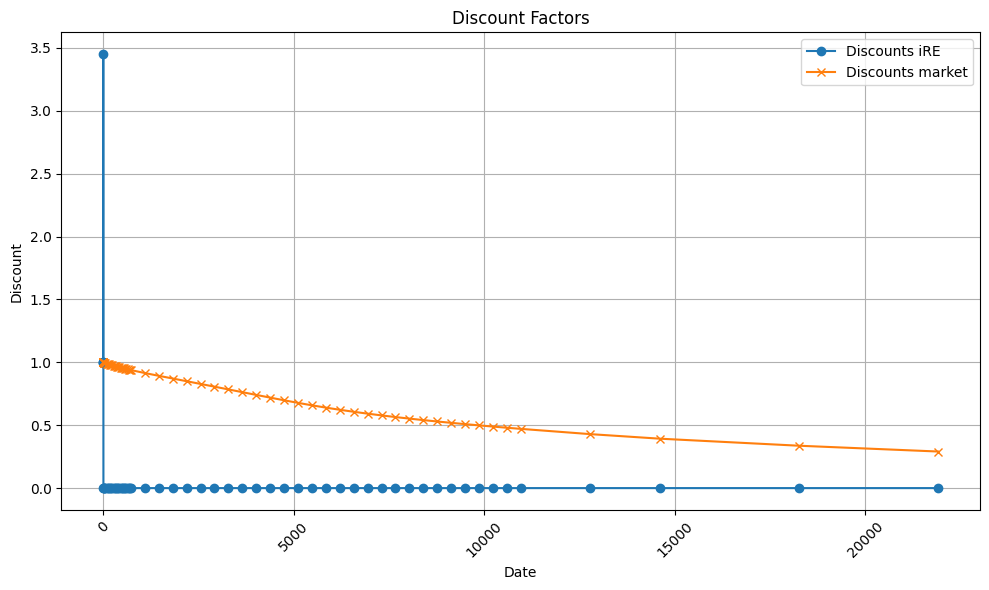

In [50]:
import matplotlib.pyplot as plt
estr_ire = bootstrapping_curve
discount_estr_ire = []
fwd_estr_ire = []
discounts_estr_mkt = ir_eur_disc_estr
for maturity in discounts_estr_mkt['daycount'].values/365:
    discount_estr_ire.append(estr_ire.discount(maturity))
    fwd_estr_ire.append(estr_ire.inst_fwd(maturity))
    
# Plot discount factors nostri vs market
plt.figure(figsize=(10, 6))
plt.plot(discounts_estr_mkt['daycount'].values, discount_estr_ire, label= 'Discounts iRE', marker='o', linestyle='-')
plt.plot(discounts_estr_mkt['daycount'].values, discounts_estr_mkt['market_quote'].values, label= 'Discounts market', marker='x', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Discount')
plt.title('Discount Factors')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Mostrare il grafico
plt.show()

In [34]:
bootstrapping_curve.set_rates(x)
res = np.zeros(len(pricers))

n = len(x)
jac = np.zeros((n, n))

for i, pricer in enumerate(pricers):
    pv, tape = pricer.price_aad(bootstrapping_curve, trade_date)
    gradients = tape.gradient(pv, [bootstrapping_curve.rates])
    res[i] = pv
    jac[i,:] = np.array(gradients[0])

In [ ]:
tol=1e-8
max_iter=100
iter_count = 0
while iter_count < max_iter:
    f = func(x)
    jac = numerical_jacobian(func, x)
    delta_x = np.linalg.solve(jac, -f)
    x += delta_x
    if np.linalg.norm(delta_x) < tol:
        break
    iter_count += 1

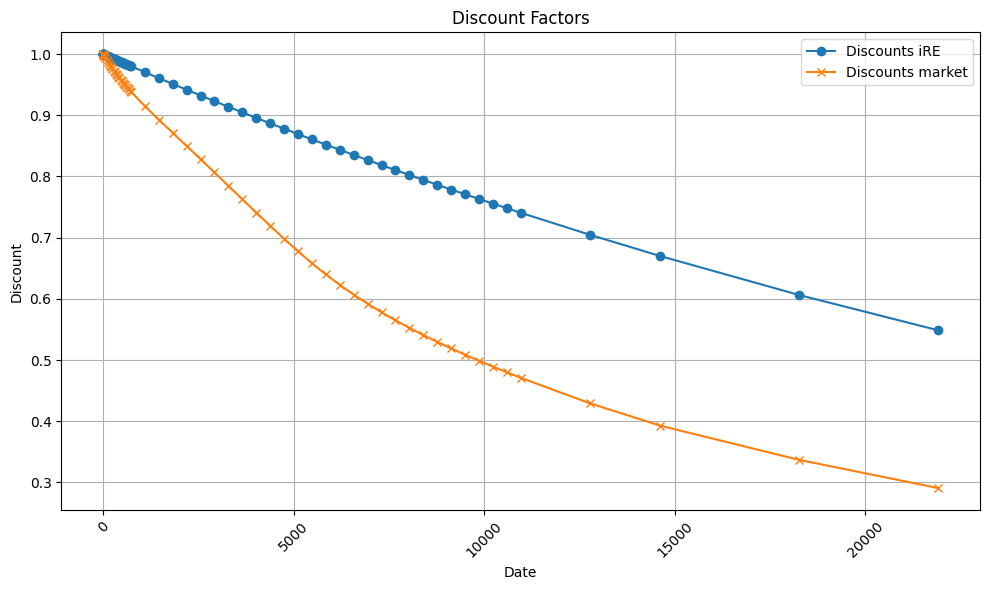

In [ ]:
import matplotlib.pyplot as plt
estr_ire = bootstrapping_curve
discount_estr_ire = []
fwd_estr_ire = []
discounts_estr_mkt = ir_eur_disc_estr
for maturity in discounts_estr_mkt['daycount'].values/365:
    discount_estr_ire.append(estr_ire.discount(maturity))
    fwd_estr_ire.append(estr_ire.inst_fwd(maturity))
    
# Plot discount factors nostri vs market
plt.figure(figsize=(10, 6))
plt.plot(discounts_estr_mkt['daycount'].values, discount_estr_ire, label= 'Discounts iRE', marker='o', linestyle='-')
plt.plot(discounts_estr_mkt['daycount'].values, discounts_estr_mkt['market_quote'].values, label= 'Discounts market', marker='x', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Discount')
plt.title('Discount Factors')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Mostrare il grafico
plt.show()

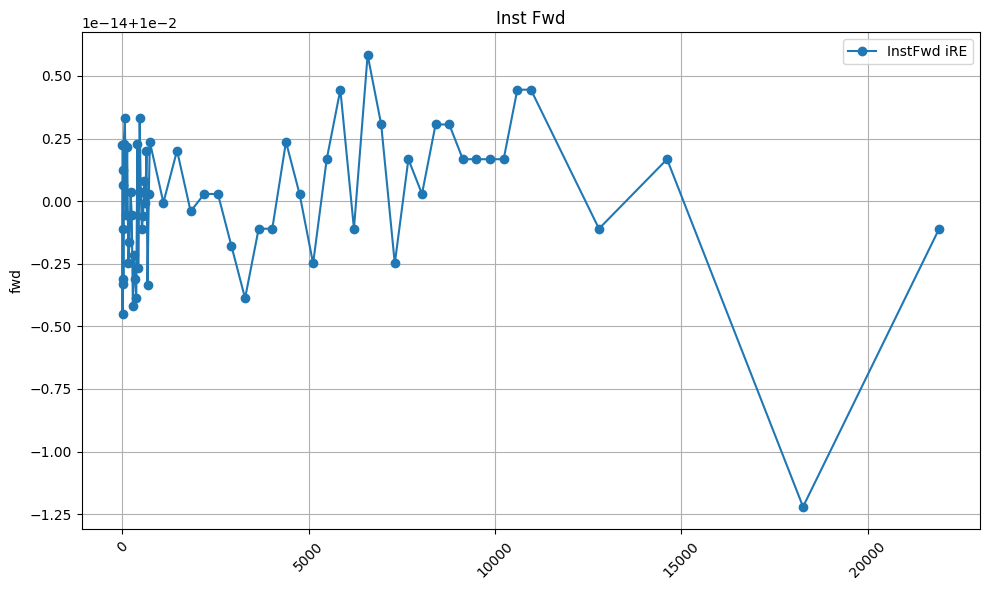

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Inst Fwd')
plt.plot(discounts_estr_mkt['daycount'].values, fwd_estr_ire, label= 'InstFwd iRE', marker='o', linestyle='-')
plt.ylabel('fwd')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Mostrare il grafico
plt.show()